In [352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

data = pd.read_csv('diamonds_1000.csv')

In [353]:
data = data.drop(columns = ['Unnamed: 0'],axis = 1)
data
data.head(12)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [354]:
Xz = stats.zscore(data[['x', 'y', 'z']])

In [355]:
uz, sz, vhz = np.linalg.svd(Xz)

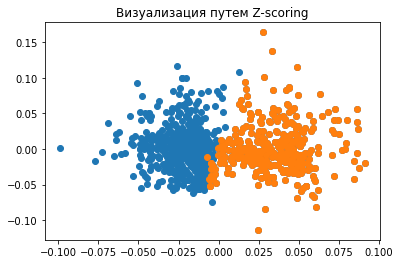

[0.58398144 0.58377928 0.56406332] [ 0.39544869  0.4022489  -0.8257216 ]


In [356]:
uz_x = -uz[:, 0]
uz_y = uz[:, 1] 
plt.scatter(uz_x, uz_y)
plt.scatter(uz_x[Xz.iloc[:, 0].values < 0], uz_y[Xz.iloc[:, 0].values < 0])
plt.title('Визуализация путем Z-scoring')
plt.show()

print(vhz[0], vhz[1])

In [357]:
dt = data[['x', 'y', 'z']]
Xr = (dt - dt.mean()) / (dt.max() - dt.min())

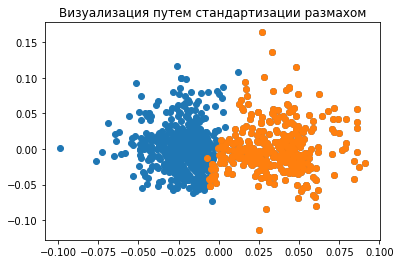

[0.6043489  0.56839461 0.55829201] [ 0.404636    0.38466325 -0.82964082]


In [358]:
uz, sz, vhz = np.linalg.svd(Xr)

uz_x = -uz[:, 0]
uz_y = uz[:, 1] 
plt.scatter(uz_x, uz_y)
plt.scatter(uz_x[Xr.iloc[:, 0].values < 0], uz_y[Xr.iloc[:, 0].values < 0])
plt.title('Визуализация путем стандартизации размахом')
plt.show()
print(vhz[0], vhz[1])

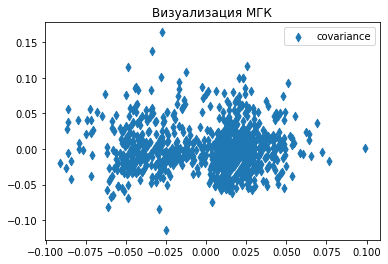

In [359]:
cov = np.dot(Xz.T, Xz) / Xz.shape[0]
e1, e2 = np.linalg.eig(cov)

pca0 = np.dot(Xz, -e2[:,0]) / np.sqrt(Xz.shape[0]*e1[0])

cov = cov - e1[0] * e2[:,0][:, None] * e2[:,0]
e1, e2 = np.linalg.eig(cov)

pca1 = np.dot(Xz, -e2[:,0]) / np.sqrt(Xz.shape[0]*e1[0])

#plt.scatter(-uz0, uz1, marker='D', label='SVD')
plt.scatter(pca0, pca1, marker='d', label='covariance')
plt.title('Визуализация МГК')
plt.legend()
plt.show()

In [360]:
from sklearn.cluster import KMeans

def make_clusters(data1, n_clusters): 
    inertias = [] 
    labels = [] 
    for i in range(10): 
        kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=1) 
        kmeans.fit(data1)
        inertias.append(kmeans.inertia_) 
        labels.append(kmeans.labels_) 
    return inertias, labels

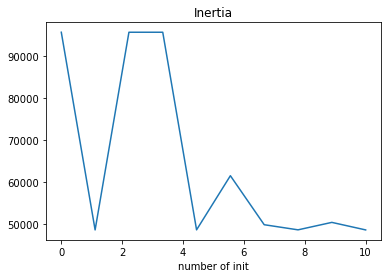

In [361]:
data1 = data[['price', 'carat', 'depth', 'table']]
inertias_for_5, labels_for_5 = make_clusters(data1, 5)
x = np.linspace(0, 10, 10) 
plt.plot(x, inertias_for_5) 
plt.xlabel('number of init') 
plt.title('Inertia') 
plt.show()

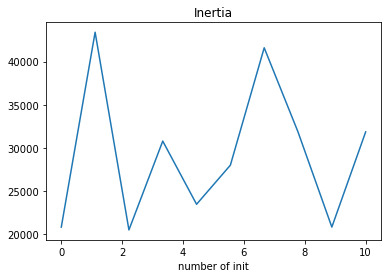

In [362]:
inertias_for_9, labels_for_9 = make_clusters(data1, 9)
x = np.linspace(0, 10, 10) 
plt.plot(x, inertias_for_9) 
plt.xlabel('number of init') 
plt.title('Inertia') 
plt.show()

In [363]:
pr = ['price', 'carat', 'depth', 'table']

def mean_cl(inertias, labels):
    opt_ind = np.argmin(inertias)
    opt_criterion = inertias[opt_ind]
    opt_label = labels[opt_ind]
    
    data1 = data[pr].copy(deep=True)
    data1.loc[:, 'cluster'] = opt_label
    cl_mean = data1.groupby('cluster').mean()
    cl_mean.loc['Grand mean', :] = data1.mean()
    return cl_mean

In [364]:
mean_cl(inertias_for_5, labels_for_5)

,price,carat,depth,table
cluster,,,,
0,433.869565,0.290725,61.848792,56.704348
1,417.014286,0.291333,61.855238,57.432381
2,362.389831,0.260508,61.858475,57.721186
3,450.483986,0.300178,61.706050,56.814235
4,394.353261,0.278043,61.675543,57.595652
Grand mean,419.293000,0.287610,61.779300,57.172100


In [365]:
def std_cl(inertias, labels):
    opt_ind = np.argmin(inertias)
    opt_criterion = inertias[opt_ind]
    opt_label = labels[opt_ind]
    
    data1 = data[pr].copy(deep=True)
    data1.loc[:, 'cluster'] = opt_label
    
    cl = data1.groupby('cluster').mean()
    delta = (cl - data1.mean()) / data1.mean() * 100
    delta.loc[:, 'Number of objects'] = data1.groupby('cluster').size()
    return delta[pr + ['Number of objects']]

In [366]:
std_cl(inertias_for_5, labels_for_5)

,price,carat,depth,table,Number of objects
cluster,,,,,
0,3.476463,1.082938,0.112485,-0.818148,207
1,-0.543466,1.294577,0.122918,0.455259,210
2,-13.571219,-9.423012,0.128157,0.960410,118
3,7.438947,4.369784,-0.118568,-0.625944,281
4,-5.948046,-3.326213,-0.167947,0.740837,184


In [367]:
mean_cl(inertias_for_9, labels_for_9)

,price,carat,depth,table
cluster,,,,
0,447.905028,0.304190,61.863687,56.846369
1,391.188034,0.283162,61.788034,57.580342
2,430.333333,0.286146,62.061458,56.410417
3,404.981651,0.279358,61.609174,57.469725
4,436.716814,0.293805,61.675221,56.932743
5,419.591195,0.290126,61.846541,57.498742
6,455.009804,0.293137,61.429412,56.757843
7,346.472222,0.258056,61.763889,57.861111
8,370.179775,0.265056,61.921348,57.664045


In [368]:
std_cl(inertias_for_9, labels_for_9)

,price,carat,depth,table,Number of objects
cluster,,,,,
0,6.823874,5.764731,0.136595,-0.569738,179
1,-6.702942,-1.546402,0.014138,0.714058,117
2,2.633083,-0.509081,0.456720,-1.332264,96
3,-3.413210,-2.869233,-0.275377,0.520577,109
4,4.155522,2.154066,-0.168469,-0.418660,113
5,0.071119,0.874721,0.108840,0.571331,159
6,8.518340,1.921788,-0.566352,-0.724579,102
7,-17.367516,-10.275875,-0.024945,1.205153,36
8,-11.713342,-7.841807,0.229929,0.860463,89
